In [1]:
import numpy as np
import cv2
import misc
# from RL_networks import Stand_alone_net
# import pickle
# import random

import tensorflow as tf
import tensorflow.keras as keras

# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

# np.__version__

import matplotlib.pyplot as plt
# %matplotlib notebook
%matplotlib inline
import SYCLOP_env as syc

from torch.utils.data import Dataset, DataLoader

import keras_networks

In [2]:
from mnist import MNIST

mnist = MNIST('/home/labs/ahissarlab/bnassa/datasets/mnist/')
images, labels = mnist.load_training()

In [3]:
#Define function for low resolution lens on syclop
def bad_res101(img,res):
    sh=np.shape(img)
    dwnsmp=cv2.resize(img,res, interpolation = cv2.INTER_AREA)
    upsmp = cv2.resize(dwnsmp,sh, interpolation = cv2.INTER_AREA)
    
    return upsmp

In [11]:
# def generate_eclamp_traj(timesteps = 5 ,res = 6, random_dir = True):
def generate_eclamp_traj(timesteps = 5 ,res = 6):
    fixed_dir = [0, 0, np.pi/2.0, np.pi, -np.pi/2.0, 0, np.pi/2.0, np.pi, -np.pi/2.0, 0, np.pi/2.0, np.pi, -np.pi/2.0]
    traj_list = []

    #Set the sensor and the agent
    img=misc.build_mnist_padded(1./256*np.reshape(images[0],[1,28,28]))
    scene = syc.Scene(image_matrix=img)
    sensor = syc.Sensor(winx=56,winy=56,centralwinx=28,centralwiny=28)
    agent = syc.Agent(max_q = [scene.maxx-sensor.hp.winx,scene.maxy-sensor.hp.winy])
    sensor.hp.resolution_fun = lambda x: bad_res101(x,(res,res))
#     sensor.hp.resolution_fun = lambda x: bad_res101(x,(res,res))


    for img_num,img in enumerate(images):
        #Set the padded image
        img=misc.build_mnist_padded(1./256*np.reshape(img,[1,28,28]))
    #     print("img: ", img_num)

        #Set the scene
        scene = syc.Scene(image_matrix=img)

        starting_point = np.array([agent.max_q[0]//2,agent.max_q[1]//2],dtype=int)
#         starting_point += np.random.randint(-5,5,2)
        
        #Set the agent & the first coord
        steps  = []
        agent.reset()
        
        agent.set_manual_q(starting_point)
        q1, ssteps = sensor.eclamp_step(scene, agent, fixed_dir[0]+np.pi)#taking one step in the opposite direction
        steps.append(q1)
#         steps.append(starting_point*1)
        
#         agent.set_manual_q(q1)
#         sensor.update(scene, agent)
        
        for j in range(timesteps):
#             if random_dir:
#                 ssteps = sensor.eclamp_max_substeps
#                 while ssteps == sensor.eclamp_max_substeps:
#                     agent.set_manual_q(steps[-1])
#                     phi = 2 * np.pi * random.random()
#                     q1, ssteps = sensor.eclamp_step(scene, agent, phi)
#             else:
#             agent.set_manual_q(steps[j])
            phi = fixed_dir[j]
            q1, ssteps = sensor.eclamp_step(scene, agent, phi)
#             print(q1,ssteps)
            
            if j==0:
                q1 = starting_point
                agent.set_manual_q(q1)
#                 print(q1,'0')
                
            steps.append(q1)

        q_sequence = np.array(steps).astype(int)
        traj_list.append(q_sequence)
        
    return traj_list

In [ ]:
def generate_fixed_traj(q_sequence):
    
    traj_list = []
    for img_num,img in enumerate(images):
        traj_list.append(q_sequence)
    
    return traj_list

In [ ]:
def generate_fixed_traj_rand_start_point():
     
    traj_diff = [[2,0], [0,2], [-2,0], [0,-3]]
    traj_list = []

    for img_num,img in enumerate(images):
        starting_point = np.array([agent.max_q[0]//2,agent.max_q[1]//2])
        starting_point += np.random.randint(-5,5,2)
        
        steps = []
        steps.append(starting_point*1)
        for j in range(4):
            starting_point += traj_diff[j]
            steps.append(starting_point*1)
                
        
        traj_list.append(steps)
    
    return traj_list

In [7]:
def create_dataset(images, labels, res, steps = 5, mixed_state = True, add_traject = True,
                   trajectory_list=None,return_datasets=False, dvs_img = False):
    '''
    Creates a torch dataloader object of syclop outputs 
    from a list of images and labels.
    
    Parameters
    ----------
    images : List object holding the images to proces
    labels : List object holding the labels
    res : resolution dawnsampling factor - to be used in cv.resize(orig_img, res)
    sample: the number of samples to have in syclop
    mixed_state : if False, use the same trajectory on every image.
    return_datasets: rerutns datasets rather than dataloaders
    Returns
    -------
    train_dataloader, test_dataloader - torch DataLoader class objects

    '''
    count = 0
    ts_images = []
    dvs_images = []
    q_seq = []
    count = 0
    #create subplot to hold examples from the dataset
    fig, ax = plt.subplots(2,5)
    i = 0 #indexises for the subplot for image and for syclop vision
    for img_num,img in enumerate(images):
        orig_img = np.reshape(img,[28,28])
        #Set the padded image
        img=misc.build_mnist_padded(1./256*np.reshape(img,[1,28,28]))
        
        if count < 5:
            ax[0,i].imshow(orig_img) 
            plt.title(labels[count])
        #Set the sensor and the agent
        scene = syc.Scene(image_matrix=img)
        sensor = syc.Sensor(winx=56,winy=56,centralwinx=28,centralwiny=28)
        agent = syc.Agent(max_q = [scene.maxx-sensor.hp.winx,scene.maxy-sensor.hp.winy])
        #Setting the coordinates to visit
        if trajectory_list is None:
            starting_point = np.array([agent.max_q[0]//2,agent.max_q[1]//2])
            starting_point += np.random.randint(-5,5,2)#eldad
            steps  = []
            for j in range(steps):
                steps.append(starting_point*1)
                starting_point += np.random.randint(-5,5,2) 

            if mixed_state:
                q_sequence = np.array(steps).astype(int)
            else:
                if count == 0:
                    q_sequence = np.array(steps).astype(int)
        else:
            q_sequence = np.array(trajectory_list[img_num]).astype(int)
        #Setting the resolution function - starting with the regular resolution
        sensor.hp.resolution_fun = lambda x: bad_res101(x,(res,res))
        #Create empty lists to store the syclops outputs
        imim=[]
        dimim=[]
        agent.set_manual_trajectory(manual_q_sequence=q_sequence)
#         if count < 5:
#             print(q_sequence.shape)
#         #setting first view for dvs - preventing "flashing"
#         if dvs_dvs_img:
#             agent.manual_act()
#             sensor.update(scene, agent)
            
        for t in range(steps):
            agent.manual_act()
            sensor.update(scene, agent)
            imim.append(sensor.central_frame_view)
            dimim.append(sensor.central_dvs_view)
        #Create a unified matrix from the list
        if count < 5:
            ax[1,i].imshow(imim[0]) 
            plt.title(labels[count])
            i+=1
            

        imim = np.array(imim)
        dimim = np.array(dimim)
        #Add current proccessed image to lists
        ts_images.append(imim)
        dvs_images.append(dimim[1:])
        q_seq.append(q_sequence)
        count += 1
        

    
    if add_traject: #If we add the trjectories the train list will become a list of lists, the images and the 
        #corrosponding trajectories, we will change the dataset structure as well. Note the the labels stay the same.
        if dvs_img:
            ts_train = [dvs_images[:55000], q_seq[:55000]] 
            ts_val = [dvs_images[55000:], q_seq[55000:]]
        else:
            ts_train = [ts_images[:55000], q_seq[:55000]] 
            ts_val = [ts_images[55000:], q_seq[55000:]]
    else:
        if dvs_img:
            dvs_train = dvs_images[:55000]
            dvs_val = dvs_images[55000:]
        else:
            ts_train = ts_images[:55000]
            ts_val = ts_images[55000:]
    
    train_labels = labels[:55000]
    val_labels = labels[55000:]
    
    
    class mnist_dataset(Dataset):
        def __init__(self, data, labels, add_traject = False, transform = None):

            self.data = data
            self.labels = labels

            self.add_traject = add_traject
            self.transform = transform
        def __len__(self):
            if self.add_traject: 
                return len(self.data[0]) 
            else: return len(self.data[0])


        def __getitem__(self, idx):
            '''
            args idx (int) :  index

            returns: tuple(data, label)
            '''
            if self.add_traject:
                img_data = self.data[0][idx] 
                traject_data = self.data[1][idx]
                label = self.labels[idx]
                return img_data, traject_data, label
            else:
                data = self.data[idx]



            if self.transform:
                data = self.transform(data)
                return data, label
            else:
                return data, label

        def dataset(self):
            return self.data
        def labels(self):
            return self.labels
        
    train_dataset = mnist_dataset(ts_train, train_labels,add_traject = True)
    test_dataset = mnist_dataset(ts_val, val_labels,add_traject = True)
    batch = 64
#     train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = batch, shuffle = True)
#     test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = batch, shuffle = True)

    if return_datasets:
        return train_dataset, test_dataset
    else:
        return train_dataloader, test_dataloader, ts_train, train_labels


In [8]:
def split_dataset_xy(dataset, timesteps_s = 0, timesteps_e = 5):
    dataset_x1 = [uu[0] for uu in dataset]
    dataset_x2 = [uu[1] for uu in dataset]
    dataset_y = [uu[-1] for uu in dataset]
    return (np.array(dataset_x1)[...,np.newaxis],np.array(dataset_x2)[:,timesteps_s:timesteps_e,:]),np.array(dataset_y)

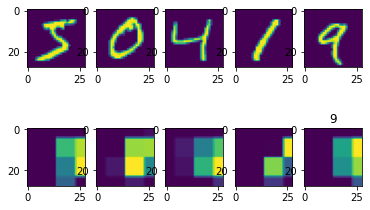

In [12]:
res = 6
ts = 5

dvsi = True
if dvsi:
#     q_seq = [[34,36],[36,36],[38,36],[38,38],[36,38],[36,36]]#first coord is supposed to be ignored
#     traj_l = generate_fixed_traj(q_seq)

    traj_l = generate_eclamp_traj(ts, res)

    train_dataset, test_dataset = create_dataset(images, labels,
                                             res = res,return_datasets=True,
                                             steps = ts+1,
                                             dvs_img = dvsi,trajectory_list = traj_l)

    train_dataset_x, train_dataset_y = split_dataset_xy(train_dataset, 1, ts+1)
    test_dataset_x, test_dataset_y = split_dataset_xy(test_dataset, 1, ts+1)

else:
    q_seq = [[36,36],[38,36],[38,38],[36,38],[36,35]]
    traj_l = generate_fixed_traj(q_seq)
    
    #     traj_l = generate_eclamp_traj(ts, res)

    train_dataset, test_dataset = create_dataset(images, labels,
                                             res = res,return_datasets=True,
                                             steps = ts,
                                             dvs_img = dvsi,trajectory_list = traj_l)

    train_dataset_x, train_dataset_y = split_dataset_xy(train_dataset, 0, ts)
    test_dataset_x, test_dataset_y = split_dataset_xy(test_dataset, 0, ts)


In [22]:
train_dataset_x[1].shape

(55000, 5, 2)

In [ ]:
import random

# traj_l_const_start_100 = traj_l

# print(traj_l[0])
# random.shuffle(traj_l)
# print(traj_l[0])

train_dataset, test_dataset = create_dataset(images, labels,
                                             res = res,return_datasets=True,
                                             steps = ts+1,
                                             dvs_img = dvsi,trajectory_list = traj_l)

train_dataset_x, train_dataset_y = split_dataset_xy(train_dataset, 1, ts+1)
test_dataset_x, test_dataset_y = split_dataset_xy(test_dataset, 1, ts+1)

In [ ]:
rnn102 = keras_networks.rnn_model_102(n_timesteps=ts,
                                      lr=2e-3,dropout=0.0,
                                      ignore_input_B=True,
                                      rnn_type='gru',
                                      input_size=(28,28,1),
                                      conv_fe=False)
  

print("Fit model on training data")
history = rnn102.fit(
            train_dataset_x,
            train_dataset_y,
            batch_size=64,
            epochs=2,
            # We pass some validation for
            # monitoring validation loss and metrics
            # at the end of each epoch
            validation_data=(test_dataset_x, test_dataset_y)) #

In [ ]:
def run_keras_lowres_eclamp(res_list = [6], timesteps = 5, random_dir = False, dvs_imgs = False, ignore_seq = False, cnn = True):
    # RES_LIST = [4, 6, 8, 10, 12]
    # RES_LIST = [6]
#     TIMESTEPS = 5

    traj_l = []
#     q_seq = [[36,36],[38,36],[38,38],[36,38],[36,35]]
    acc = np.zeros(len(res_list))
    val_acc = np.zeros(len(res_list))
    for indx,res in enumerate(res_list):

    #     traj_l = generate_fixed_traj(q_seq)
        traj_l = generate_eclamp_traj(timesteps, res, random_dir = False)
    #     traj_l = generate_fixed_traj_rand_start_point()

        train_dataset, test_dataset = create_dataset(images, labels,
                                                     res = res,return_datasets=True, 
                                                     dvs_images = dvs_imgs,trajectory_list = traj_l)
    #     train_dataset, test_dataset = create_dataset(images, labels,res = res,return_datasets=True)

        train_dataset_x, train_dataset_y = split_dataset_xy(train_dataset, timesteps)
        test_dataset_x, test_dataset_y = split_dataset_xy(test_dataset, timesteps)

        rnn102 = keras_networks.rnn_model_102(n_timesteps=timesteps,
                                              lr=1e-3,dropout=0.0,
                                              ignore_input_B = ignore_seq,
                                              rnn_type='gru',
                                              input_size=(28,28,1),
                                              conv_fe=cnn)
    #     rnn = rnn_model(timesteps)

        print("Fit model on training data")
        history = rnn102.fit(
            train_dataset_x,
            train_dataset_y,
            batch_size=64,
            epochs=1,
            # We pass some validation for
            # monitoring validation loss and metrics
            # at the end of each epoch
            validation_data=(test_dataset_x, test_dataset_y)) #(validation_images, validation_labels)


        acc[indx] = history.history['sparse_categorical_accuracy'][0]
        val_acc[indx] = history.history['val_sparse_categorical_accuracy'][0]

    return acc, val_acc


In [ ]:
RES_LIST = [4, 6, 8, 10, 12]

# acc_eclamp_base, val_acc_eclamp_base = run_keras_lowres_eclamp(res_list = RES_LIST, 
#                                                                timesteps = 5, random_dir = False, 
#                                                                dvs_imgs = False, ignore_seq = False, cnn = True)
# acc_eclamp_base_nocnn, val_acc_eclamp_nocnn = run_keras_lowres_eclamp(res_list = RES_LIST, 
#                                                                timesteps = 5, random_dir = False, 
#                                                                dvs_imgs = False, ignore_seq = False, cnn = False)
# acc_eclamp_base_noseq, val_acc_eclamp_noseq = run_keras_lowres_eclamp(res_list = RES_LIST, 
#                                                                timesteps = 5, random_dir = False, 
#                                                                dvs_imgs = False, ignore_seq = True, cnn = True)
# acc_eclamp_base_dvs, val_acc_eclamp_dvs = run_keras_lowres_eclamp(res_list = RES_LIST, 
#                                                                timesteps = 5, random_dir = False, 
#                                                                dvs_imgs = True, ignore_seq = False, cnn = True)
# acc_eclamp_base_dvs_nocnn, val_acc_eclamp_dvs_nocnn = run_keras_lowres_eclamp(res_list = RES_LIST, 
#                                                                timesteps = 5, random_dir = False, 
#                                                                dvs_imgs = True, ignore_seq = False, cnn = False)
acc_eclamp_base_dvs_nocseq, val_acc_eclamp_dvs_noseq = run_keras_lowres_eclamp(res_list = RES_LIST, 
                                                               timesteps = 5, random_dir = False, 
                                                               dvs_imgs = True, ignore_seq = True, cnn = True)


In [ ]:
plt.figure()
plt.plot(RES_LIST, val_acc_eclamp_base, 'ob')
plt.plot(RES_LIST, val_acc_eclamp_nocnn, '*r')
plt.plot(RES_LIST, val_acc_eclamp_noseq, 'ok')
plt.plot(RES_LIST, val_acc_eclamp_dvs, 'og')
plt.plot(RES_LIST, val_acc_eclamp_dvs_nocnn, 'oy')
plt.plot(RES_LIST, val_acc_eclamp_dvs_noseq, '.g')
plt.legend(['eclamp base','eclamp w/o cnn', 'eclamp w/o sequence', 'eclamp dvs','eclamp dvs w/o cnn', 'eclamp dvs w/o sequence'])
plt.xlabel('res')
plt.ylabel('val acc')
# plt.savefig('eclamp_accuracy.png')

### Analysis and testing

In [ ]:
agent.set_manual_q(starting_point)
view0 = sensor.get_view(scene,agent)
# view0.shape

agent.set_manual_q(starting_point + [10,10])
view1 = sensor.get_view(scene,agent)

dvs_view = sensor.dvs_fun(view1,view0)

plt.figure()
plt.imshow(view0)
plt.figure()
plt.imshow(view1)
plt.figure()
plt.imshow(dvs_view)
# view0

In [ ]:
# im=misc.build_mnist_padded(1./256*np.reshape(images[3],[1,28,28]))
plt.figure()
# plt.imshow(im)

traj_1 = train_dataset_x[1][train_dataset_y==1,:,:]
traj_0 = train_dataset_x[1][train_dataset_y==0,:,:]
traj_2 = train_dataset_x[1][train_dataset_y==2,:,:]

for seq in traj_0[:10]:
    plt.plot(seq[:5,0],seq[:5,1], 'b')
for seq in traj_1[:10]:
    plt.plot(seq[:5,0],seq[:5,1], 'r')
# for seq in traj_2[:10]:
#     plt.plot(seq[:5,0],seq[:5,1], 'g')

plt.axis('equal')
print(seq)

In [ ]:
plt.figure()
plt.hist(train_dataset_x[1][train_dataset_y==0,0,0], bins=20)

plt.figure()
plt.hist(train_dataset_x[1][train_dataset_y==1,0,0], bins=20)

plt.figure()
plt.hist(train_dataset_x[1][train_dataset_y==2,0,0], bins=20)

plt.figure()
plt.hist(train_dataset_x[1][train_dataset_y==3,0,0], bins=20)

plt.figure()
plt.hist(train_dataset_x[1][train_dataset_y==4,0,0], bins=20)

plt.figure()
plt.hist(train_dataset_x[1][train_dataset_y==5,0,0], bins=20)

In [ ]:
img_ind = 2
# print(train_dataset_x[1][img_ind,:,:]-22)

plt.figure()
plt.imshow(train_dataset_x[0][img_ind,0,:,:,0])
plt.figure()
plt.imshow(train_dataset_x[0][img_ind,1,:,:,0])
plt.figure()
plt.imshow(train_dataset_x[0][img_ind,2,:,:,0])
plt.figure()
plt.imshow(train_dataset_x[0][img_ind,3,:,:,0])
plt.figure()
plt.imshow(train_dataset_x[0][img_ind,4,:,:,0])

train_dataset_x[1][0]

In [ ]:
img = misc.build_mnist_padded(1./256*np.reshape(images[8],[1,28,28]))

q = [36,36]
view =  img[128 - q[1] - 56: 128 - q[1], q[0]: q[0] + 56]
view_bad_res = bad_res101(view,(28,28))

plt.figure()
plt.imshow(view_bad_res)
print((view_bad_res==0.0).all())

In [ ]:
indxs_empty = []
sum_empty = 0
for tx_ind, tx in enumerate(train_dataset_x):
    for view in tx[:1]:
#     for view in tx:
#         plt.figure()
#         plt.imshow(view)
         sum_empty += (view==0).all()
         if (view==0).all():
             indxs_empty.append(tx_ind)

print(sum_empty) 

In [ ]:
test_predictions = rnn.predict(test_dataset_x)

In [ ]:
predicted_digit = []
for sample_pred in test_predictions:
    pred = np.where(sample_pred == np.max(sample_pred))
    predicted_digit.append(pred[0][0])

predicted_digit = np.array(predicted_digit)

In [ ]:
digit = 1
np.sum(predicted_digit[test_dataset_y==digit]==digit)/np.sum(test_dataset_y==digit)

In [ ]:
print(train_dataset_x[1][0,:,:])
print(traj_l[0])
# plt.figure()
# plt.plot(traj_l[1][:,0],traj_l[1][:,1], 'b')
# len(train_dataset[1][0])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

np_frame_filename = "./mnist_100.npz"

# Load the NumPy array mini-batch from the saved .npz file
data = np.load(np_frame_filename)
print(data['x1'].shape)
print(data['y'].shape)

# data.close()


In [ ]:
# pick a sample to plot
sample = 0
image = data['x1'][sample]
# plot the sample
fig = plt.figure()
plt.imshow(image, cmap='gray')
plt.show()
print(data['y'][sample])

In [ ]:
np.sum(data['x1'][0])

In [ ]:
event_cnt = 100
max_q = 56
eclamp_substep_r = 0.5
phi = np.pi/2.0
q1_ana = [39,36]

for i in range(20):
            
    q1_ana[0] = q1_ana[0] + eclamp_substep_r * np.cos(phi)
    q1_ana[1] = q1_ana[1] + eclamp_substep_r * np.sin(phi)
            
    q1_ana = np.minimum(q1_ana,max_q) # enforce_bounderies ??
    q1_ana = np.maximum(q1_ana,[0.0, 0.0])
    q1 = np.int32(np.round(q1_ana))
    
    print(q1_ana,q1)
#      if (q1 != q0).any():
#                 agent.set_manual_q(q1)
#     #             self.update(scene,agent)
#                 view1 = self.get_view(scene,agent)
#                 view1_cw = view1[self.cwy1:self.cwy2,self.cwx1:self.cwx2]
#                 dvs_view = self.dvs_fun(view1_cw, view0_cw)
#                 evnt_cnt = np.sum(np.abs(dvs_view))

#             substeps+=1